In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
import shap
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pickle


In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/vibration-analysis-on-rotating-shaft/4D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/2E.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/0E.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/2D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/0D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/1D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/4E.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/3D.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/1E.csv
/kaggle/input/vibration-analysis-on-rotating-shaft/3E.csv


In [5]:
def split_and_select(dataset, num_categories=5, test_ratio=0.01):
   
    # Calculate the size of each category
    category_size = len(dataset) // num_categories

    # Initialize an empty list to store selected subsets
    selected_data = []

    # Split dataset into categories and select 10% from each category
    for i in range(num_categories):
        # Calculate start and end indices for the current category
        start_idx = i * category_size
        end_idx = (i + 1) * category_size

        # Select 10% of data from the current category
        test_start = int(start_idx + (1 - test_ratio) * category_size)
        test_end = int(start_idx + category_size)
        selected_data.append(dataset[test_start:test_end])

    # Concatenate selected subsets from each category
    selected_subset = pd.concat(selected_data)

    return selected_subset

In [6]:
def process_dataset(target_name, target_value):
    
    df0 = pd.read_csv("/kaggle/input/vibration-analysis-on-rotating-shaft/0D.csv").drop_duplicates()
    df1 = pd.read_csv("/kaggle/input/vibration-analysis-on-rotating-shaft/1D.csv").drop_duplicates()
    df2 = pd.read_csv("/kaggle/input/vibration-analysis-on-rotating-shaft/2D.csv").drop_duplicates()
    df3 = pd.read_csv("/kaggle/input/vibration-analysis-on-rotating-shaft/3D.csv").drop_duplicates()
    df4 = pd.read_csv("/kaggle/input/vibration-analysis-on-rotating-shaft/4D.csv").drop_duplicates()

    # Add target column
    df0["target"] = 0
    df1[target_name] = target_value
    df2[target_name] = target_value
    df3[target_name] = target_value
    df4[target_name] = target_value
    
    df0 = split_and_select(df0)
    df1 = split_and_select(df1)
    df2 = split_and_select(df2)
    df3 = split_and_select(df3)
    df4 = split_and_select(df4)
    
    # Concatenate datasets
    concatenated_df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)
    
    return concatenated_df

In [7]:
df = process_dataset('target', 1)
len(df)

1319960

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("target", axis=1),df["target"], test_size =0.1, random_state=42)

In [9]:
X_train_fft = np.abs(np.fft.rfft(X_train, axis=1))
X_test_fft = np.abs(np.fft.rfft(X_test, axis=1))

In [10]:
X_train_fft.shape

(1187964, 3)

In [11]:
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train_fft, y_train)

# Generate predictions
predictions = model.predict(X_test_fft)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     26220
           1       1.00      1.00      1.00    105776

    accuracy                           1.00    131996
   macro avg       1.00      1.00      1.00    131996
weighted avg       1.00      1.00      1.00    131996



In [12]:
# Print confusion matrix
print("\nRandon Forest Confusion Matrix:")
print(confusion_matrix(y_test, predictions))


Randon Forest Confusion Matrix:
[[ 26093    127]
 [   139 105637]]


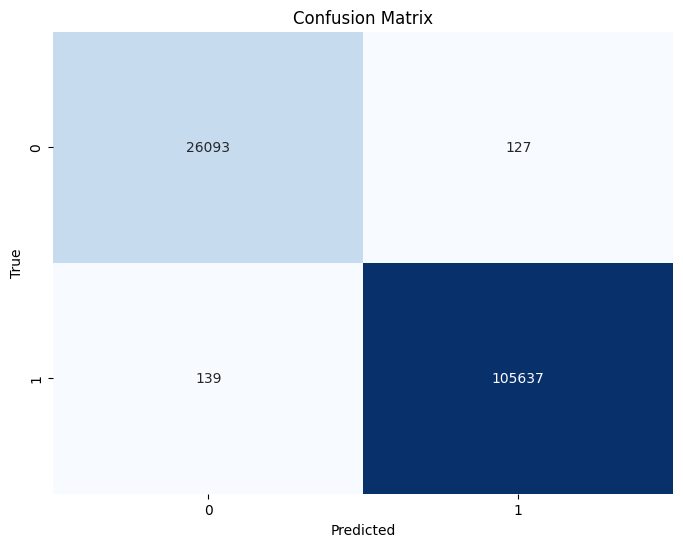

In [13]:
# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)
 
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
base_classifiers = [
    ('decision_tree', DecisionTreeClassifier()),
    ('random_forest', RandomForestClassifier(n_estimators=50)),  # Random Forest instead of SVM
]

# Initialize meta classifier
meta_classifier = LogisticRegression()

# Initialize Stacking classifier
stacking_model = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# Train the model
stacking_model.fit(X_train_fft, y_train)

# Generate predictions
stacking_predictions = stacking_model.predict(X_test_fft)

# Print classification report
print("Stacking Classification Report:")
print(classification_report(y_test, stacking_predictions))

Stacking Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     26220
           1       1.00      1.00      1.00    105776

    accuracy                           1.00    131996
   macro avg       1.00      1.00      1.00    131996
weighted avg       1.00      1.00      1.00    131996



In [15]:
# Print confusion matrix
print("\nStacking Confusion Matrix:")
print(confusion_matrix(y_test, stacking_predictions))


Stacking Confusion Matrix:
[[ 26087    133]
 [   125 105651]]


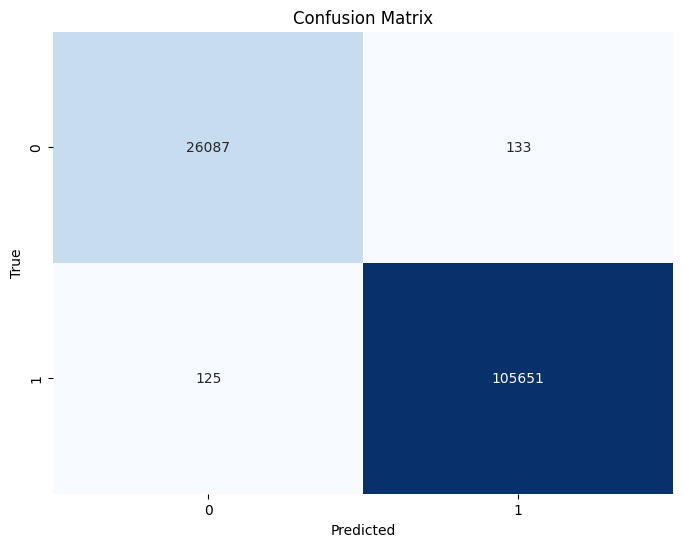

In [16]:
# Generate confusion matrix
cm = confusion_matrix(y_test, stacking_predictions)
 
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
with open('stacking_fft.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

print("Model saved as 'model.pkl'")

Model saved as 'model.pkl'
